In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

import rioxarray
import xarray
import rasterio
import xarray as xr

## GDAL
from osgeo import gdal, osr, ogr
 
## WQ_SAT
from wq_sat import config
from wq_sat.satellites import sentinel2
from wq_sat.bathymetry import SDB
from wq_sat.utils import geo_utils, plot_utils, data_utils

## Load the model to predict

In [2]:
train_region = 'CalaMillor'
train_year = '2020'
main_path = os.path.join(config.data_path(), 'bathymetries', train_region, train_year)

In [3]:
# load the Zgreen model from disk
Zgr_file = '{}_Zgreen_model_{}.sav'.format(train_region, train_year)
Zgreen_model = pickle.load(open(os.path.join(main_path, Zgr_file), 'rb'))

# load the Zred model from disk
Zr_file = '{}_Zred_model_{}.sav'.format(train_region, train_year)
Zred_model = pickle.load(open(os.path.join(main_path, Zr_file), 'rb'))

## predict pSDB

In [4]:
region = 'Ibiza'
year = '2023'
main_path = os.path.join(config.data_path(), 'bathymetries', region)

roi_coord = {'N': 38.89112, 'W': 1.16445, 'S': 38.85693, 'E': 1.23046}
tile = 'S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935'
Zgr_max, Zr_max, Rs492, Rs559, Rs704, chl, coord = SDB.wq_proxies(tile, roi_coord)

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935
Selected pixel region: xmin=4080, ymin=9374, xmax=4645, ymax=9765:
Image size: width=566 x height=392


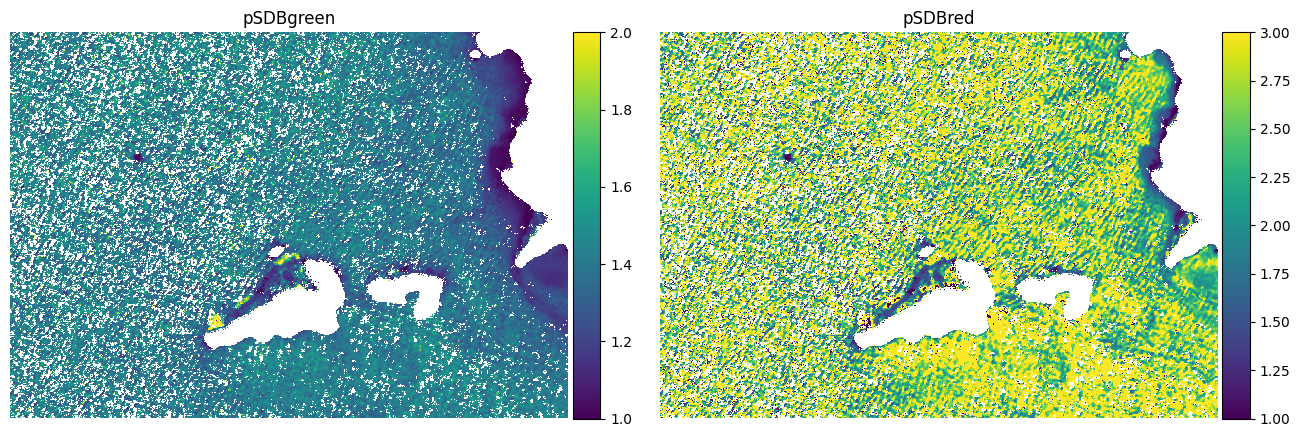

In [5]:
fig, ax = plt.subplots(1,2, figsize=(16,12))
axs = ax.flatten()

im1 = axs[0].imshow(Zgr_max, interpolation='nearest', cmap='viridis', vmin=1, vmax=2)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
axs[0].set_title('pSDBgreen')
axs[0].axis('off')

im2 = axs[1].imshow(Zr_max, interpolation='nearest', cmap='viridis', vmin=1, vmax=3)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
axs[1].set_title('pSDBred')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

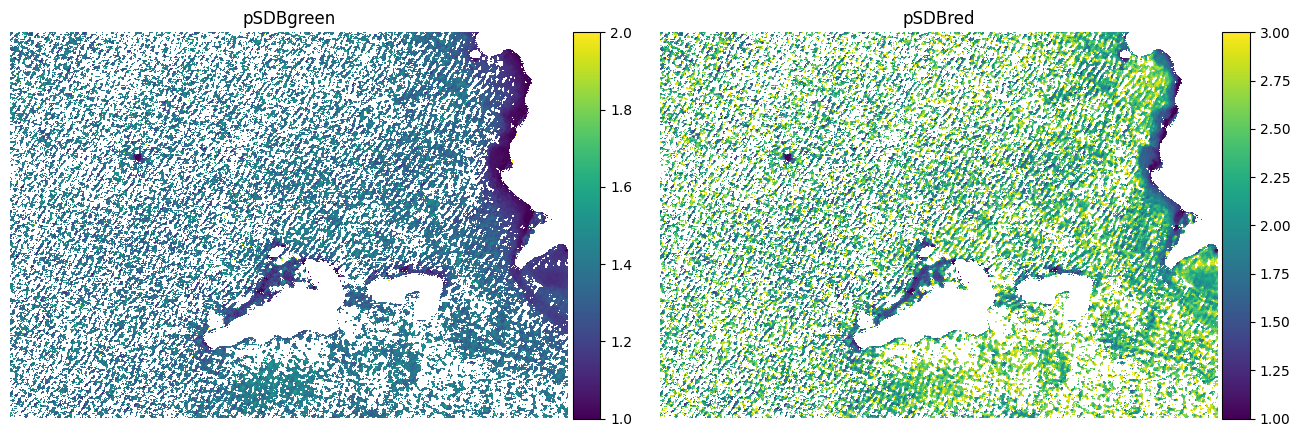

In [7]:
Zr_max[Zr_max < 0] = np.nan
Zr_max[Zr_max > 3] = np.nan
Zred_mx = np.ma.masked_invalid(Zr_max)
Zgr_max[Zred_mx.mask] = np.nan

fig, ax = plt.subplots(1,2, figsize=(16,12))
axs = ax.flatten()

im1 = axs[0].imshow(Zgr_max, interpolation='nearest', cmap='viridis', vmin=1, vmax=2)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
axs[0].set_title('pSDBgreen')
axs[0].axis('off')

im2 = axs[1].imshow(Zr_max, interpolation='nearest', cmap='viridis', vmin=1, vmax=3)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
axs[1].set_title('pSDBred')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

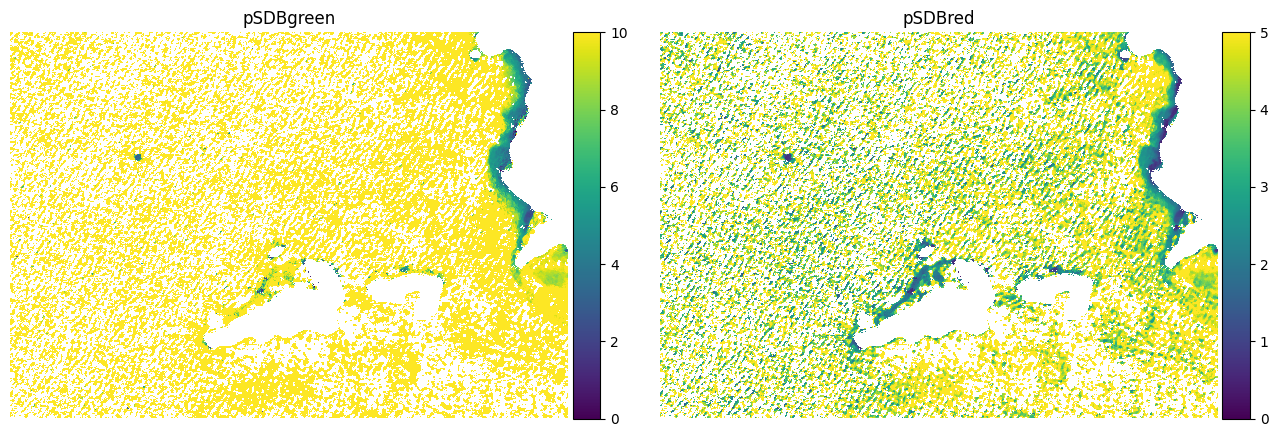

In [8]:
pSDBgreen = Zgreen_model(Zgr_max)
pSDBred = Zred_model(Zr_max)

fig, ax = plt.subplots(1,2, figsize=(16,12))
axs = ax.flatten()

im1 = axs[0].imshow(pSDBgreen, interpolation='nearest', cmap='viridis', vmin=0, vmax=10)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
axs[0].set_title('pSDBgreen')
axs[0].axis('off')

im2 = axs[1].imshow(pSDBred, interpolation='nearest', cmap='viridis', vmin=0, vmax=5)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
axs[1].set_title('pSDBred')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Switching model

In [9]:
Switching_SDB = SDB.switching_model(pSDBgreen, pSDBred)

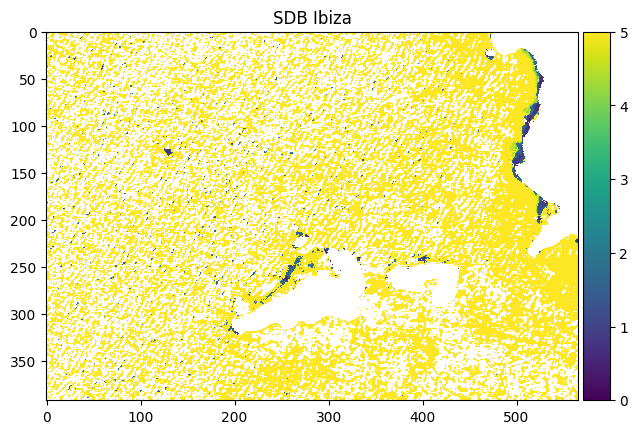

In [10]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Switching_SDB, interpolation='nearest', cmap='viridis', vmin=0, vmax=5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

## ODW

In [11]:
ODW_SDB = SDB.odw_model(Switching_SDB, Rs492, Rs559, Rs704)

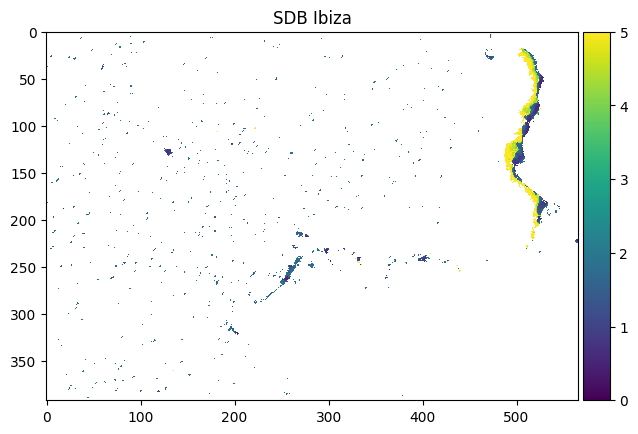

In [12]:
ODW_SDB[ODW_SDB > 6] = np.nan 

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(ODW_SDB, interpolation='nearest', cmap='viridis', vmin=0, vmax=5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

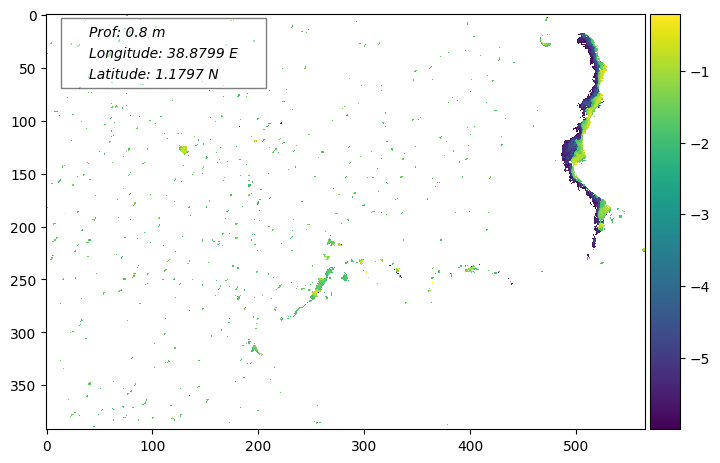

In [14]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(121)

# ax.imshow(rgb_im, extent=BBox)
im = ax.imshow(-ODW_SDB, interpolation='nearest', cmap='viridis')

ax.text(40, 40, 'Longitude: 38.8799 E', style='italic', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 20})
ax.text(40, 60, 'Latitude: 1.1797 N', style='italic')
ax.text(40, 20, 'Prof: 0.8 m', style='italic')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')

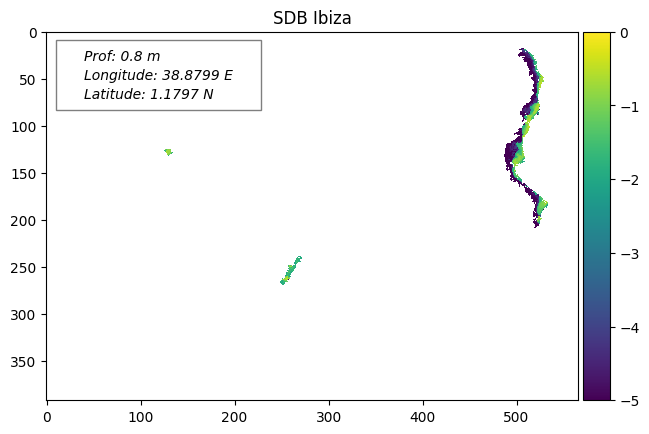

In [19]:
pSDB_map = data_utils.filter_noise(ODW_SDB ,n_thresh = 45)

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-pSDB_map, interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)

ax1.text(40, 50, 'Longitude: 38.8799 E', style='italic', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 20})
ax1.text(40, 70, 'Latitude: 1.1797 N', style='italic')
ax1.text(40, 30, 'Prof: 0.8 m', style='italic')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

In [13]:
# SDB geotiff
path = '/home/wq_sat/notebooks/bathymetries/ML_SDB/'
file = 'sdb_ibiza.tif'
geo_utils.save_gdal(os.path.join(path, file), 
                    np.expand_dims(-pSDB_map, axis=-1), 
                    ['SDB'], 
                    coord['geotransform'], 
                    coord['geoprojection'])

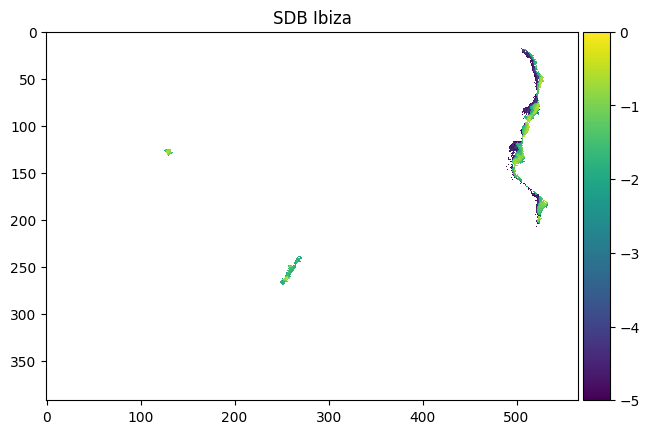

In [14]:
pSDB_map[pSDB_map > 5] = np.nan

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-pSDB_map, interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

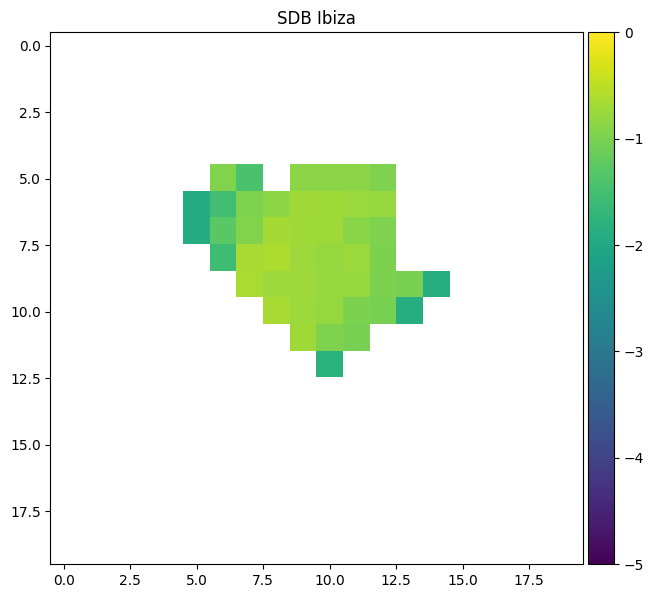

In [15]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-pSDB_map[120:140,120:140], interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

In [16]:
print(np.nanmax(-pSDB_map[120:140,120:140]))

-0.6072108745574951


<!-- ## predict pSDB -->